Chargement des données

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
import pickle
import scipy.signal


my_data = np.genfromtxt('../Supelec_2012_SIR_Spectral_Analysis_EA_v001.csv', delimiter=',')
# c'est plus rapide de charger des pickle que des csv
a="""
with open("data.pickle", "wb") as file:
    pickle.dump(my_data, file)

with open("data.pickle", "rb") as file:
    my_data = pickle.load(file)
"""

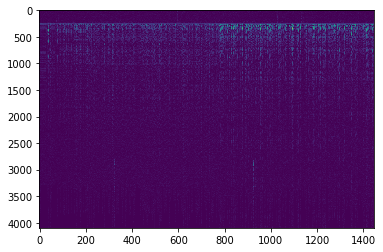

In [2]:
plt.figure()
plt.imshow(np.abs(my_data), aspect="auto")
plt.show()

Constantes

In [3]:
# paramètres du signal
Te = 10**(-6)
Fe = 1/Te

def make_cos_window(te, Tcut, length):
    dT=Tcut/16
    len1 = int((Tcut-dT)/te)
    len2 = int(dT/te)
    len3 = length - len1 - 2*len2
    cospart = np.cos(np.linspace(0, np.pi, len2))*0.5 + 0.5
    return np.concatenate([
        cospart[::-1],
        np.ones(len1),
        cospart,
        np.zeros(len3),
    ])

# fenêtre cosinus
cos_window = make_cos_window(Te, 0.6e-3, 4096)
# coefficients pour filtre de chebychev
chebyfilt = scipy.signal.cheby2(2, 40, [2e3, 2e5], fs=Fe, btype='bandpass', output='sos')


Aide à l'affichage

In [4]:
def get_fft(sig, te, absolute=True):
    N = len(sig)//2
    signal_f = np.fft.fft(sig)[:N]
    if absolute:
        signal_f = abs(signal_f)
    freqs = np.arange(0, N)*0.5/te
    return freqs, signal_f

def plot_fft(sig, te, absolute=True):
    plt.plot(*get_fft(sig, te, absolute))

Analyse d'un signal

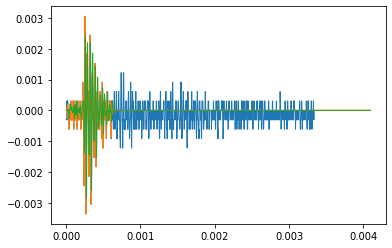

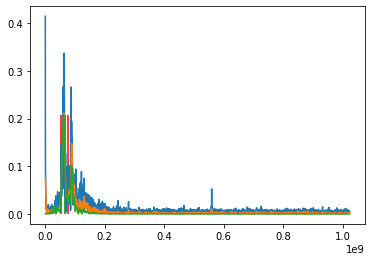

In [5]:
def sig_simple(signal):
    time = np.arange(0, len(signal))*Te
    signal_win = cos_window * signal
    signal_filt = scipy.signal.sosfilt(chebyfilt, signal_win)

    freqs, sig_tf = get_fft(signal_filt, Te)
    
    energy_f = np.multiply(sig_tf, sig_tf)
    bary_f = sum(freqs * energy_f) / sum(energy_f)
    var_f = np.sqrt( sum((freqs - bary_f)**2 * energy_f) / sum(energy_f) )

    plt.figure()
    plt.plot(time, signal, linewidth=1)
    plt.plot(time, signal_win, linewidth=1)
    plt.plot(time, signal_filt, linewidth=1)

    plt.figure()
    plot_fft(signal, Te)
    plot_fft(signal_win, Te)
    plot_fft(signal_filt, Te)
    plt.vlines([bary_f-var_f, bary_f, bary_f+var_f], 0, max(sig_tf), colors=['r', 'g', 'r'])

signal = my_data[:,101]
sig_simple(signal)    


In [6]:
def weighted_quantile(values, quantiles, sample_weight=None, 
                      values_sorted=False, old_style=False):
    """ Very close to numpy.percentile, but supports weights.
    NOTE: quantiles should be in [0, 1]!
    :param values: numpy.array with data
    :param quantiles: array-like with many quantiles needed
    :param sample_weight: array-like of the same length as `array`
    :param values_sorted: bool, if True, then will avoid sorting of
        initial array
    :param old_style: if True, will correct output to be consistent
        with numpy.percentile.
    :return: numpy.array with computed quantiles.
    """
    values = np.array(values)
    quantiles = np.array(quantiles)
    if sample_weight is None:
        sample_weight = np.ones(len(values))
    sample_weight = np.array(sample_weight)
    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), \
        'quantiles should be in [0, 1]'

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    if old_style:
        # To be convenient with numpy.percentile
        weighted_quantiles -= weighted_quantiles[0]
        weighted_quantiles /= weighted_quantiles[-1]
    else:
        weighted_quantiles /= np.sum(sample_weight)
    return np.interp(quantiles, weighted_quantiles, values)

Analyse de tous les signaux, pour extraire les paramètres significatifs

In [7]:

def extract_params(signal):
    # fenetrage
    signal_win = cos_window * signal
    
    # filtrage
    signal_filt = scipy.signal.sosfilt(chebyfilt, signal_win)

    # fft
    freqs, sig_tf = get_fft(signal_filt, Te)
    
    # moyenne
    energy_f = sig_tf**2
    bary_f = sum(freqs * energy_f) / sum(energy_f)
    # variance
    var_f = sum((freqs - bary_f)**2 * energy_f) / sum(energy_f)
    # moments (3 à 10)
    moments = [sum((freqs - bary_f)**n * energy_f) / sum(energy_f) for n in range(3, 11)]
    # fréquence max
    max_f = freqs[np.argmax(sig_tf)]
    # max par pondération suffisemment forte
    #max_f = sum(freqs * (sig_tf**20)) / sum(sig_tf**20)
    # quantiles
    q1, median, q3 = weighted_quantile(freqs, [0.25, 0.5, 0.75], sample_weight=sig_tf**2)
    
    return [bary_f, var_f] + moments + [max_f, q1, median, q3]


barys_vars_f = []
for i in range(my_data.shape[1]):
    barys_vars_f.append(extract_params(my_data[:, i]))


color = np.arange(len(barys_vars_f))


vars_f, barys_f, mom3, mom4, mom5, mom6, mom7, mom8, mom9, mom10, maxs_f, q1_f, meds_f, q3_f = zip(*barys_vars_f)

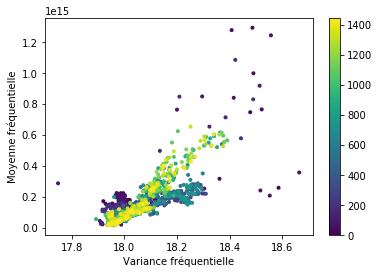

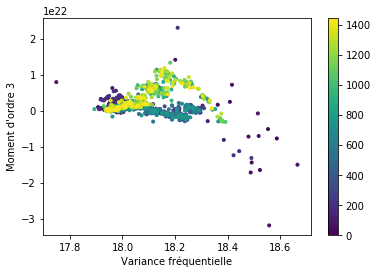

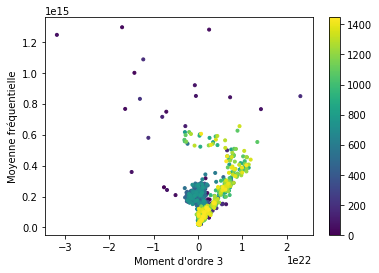

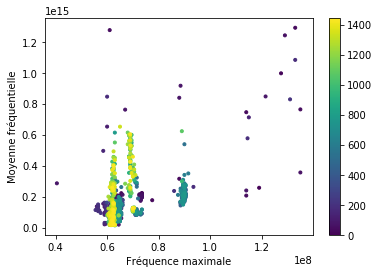

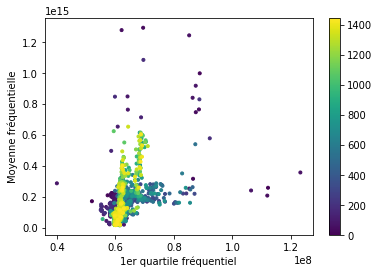

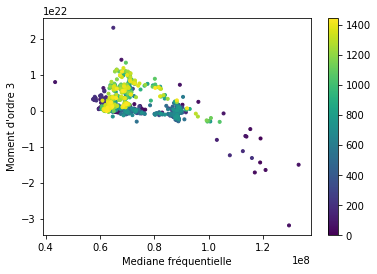

In [14]:
plt.figure()
plt.scatter(np.log(vars_f), barys_f, marker='.', c=color)
plt.xlabel("Variance fréquentielle")
plt.ylabel("Moyenne fréquentielle")
plt.colorbar()

plt.figure()
plt.scatter(np.log(vars_f), mom3, marker='.', c=color)
plt.xlabel("Variance fréquentielle")
plt.ylabel("Moment d'ordre 3")
plt.colorbar()

plt.figure()
plt.scatter(mom3, barys_f, marker='.', c=color)
plt.xlabel("Moment d'ordre 3")
plt.ylabel("Moyenne fréquentielle")
plt.colorbar()

plt.figure()
plt.scatter(maxs_f, barys_f, marker='.', c=color)
plt.xlabel("Fréquence maximale")
plt.ylabel("Moyenne fréquentielle")
plt.colorbar()

plt.figure()
plt.scatter(q1_f, barys_f, marker='.', c=color)
plt.xlabel("1er quartile fréquentiel")
plt.ylabel("Moyenne fréquentielle")
plt.colorbar()

plt.figure()
plt.scatter(meds_f, mom3, marker='.', c=color)
plt.xlabel("Mediane fréquentielle")
plt.ylabel("Moment d'ordre 3")
plt.colorbar()

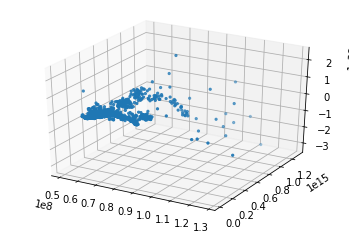

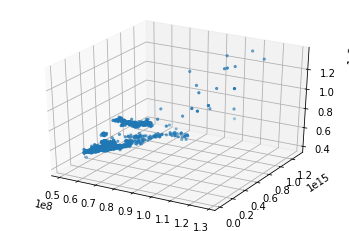

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vars_f, barys_f, mom3, marker='.')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(vars_f, barys_f, maxs_f, marker='.')

Text(0, 0.5, "Moment d'ordre 10")

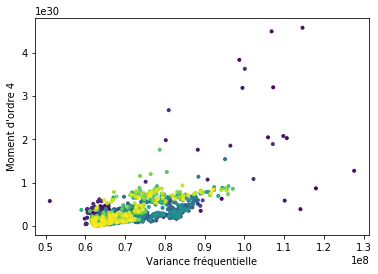

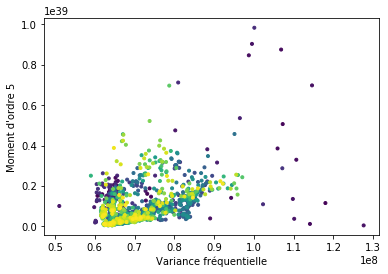

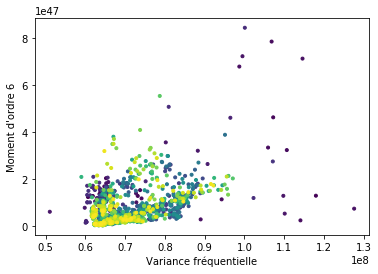

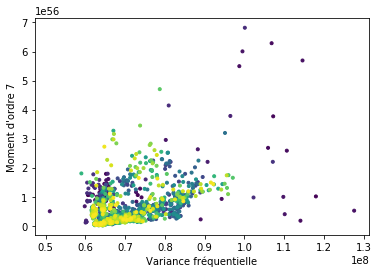

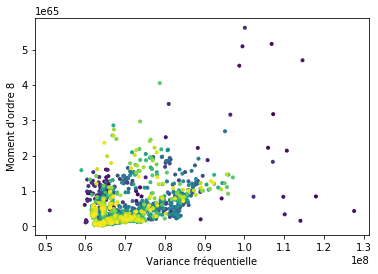

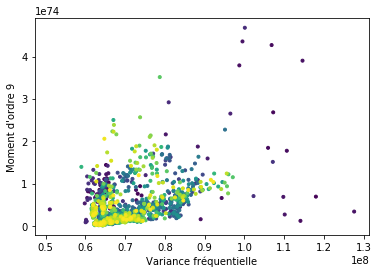

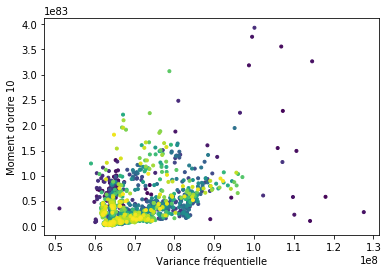

In [10]:

plt.figure()
plt.scatter(vars_f, mom4, marker='.', c=color)
plt.xlabel("Variance fréquentielle")
plt.ylabel("Moment d'ordre 4")

plt.figure()
plt.scatter(vars_f, mom5, marker='.', c=color)
plt.xlabel("Variance fréquentielle")
plt.ylabel("Moment d'ordre 5")

plt.figure()
plt.scatter(vars_f, mom6, marker='.', c=color)
plt.xlabel("Variance fréquentielle")
plt.ylabel("Moment d'ordre 6")

plt.figure()
plt.scatter(vars_f, mom7, marker='.', c=color)
plt.xlabel("Variance fréquentielle")
plt.ylabel("Moment d'ordre 7")

plt.figure()
plt.scatter(vars_f, mom8, marker='.', c=color)
plt.xlabel("Variance fréquentielle")
plt.ylabel("Moment d'ordre 8")

plt.figure()
plt.scatter(vars_f, mom9, marker='.', c=color)
plt.xlabel("Variance fréquentielle")
plt.ylabel("Moment d'ordre 9")

plt.figure()
plt.scatter(vars_f, mom10, marker='.', c=color)
plt.xlabel("Variance fréquentielle")
plt.ylabel("Moment d'ordre 10")


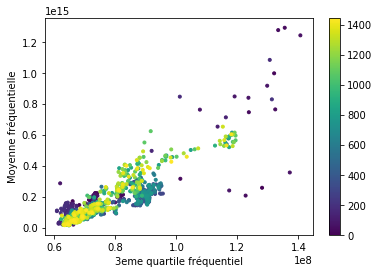

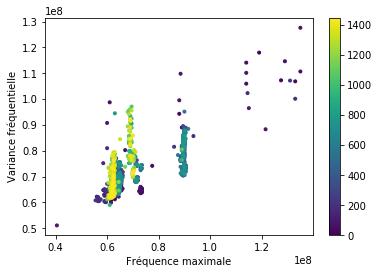

In [11]:
plt.figure()
plt.scatter(q3_f, barys_f, marker='.', c=color)
plt.xlabel("3eme quartile fréquentiel")
plt.ylabel("Moyenne fréquentielle")
plt.colorbar()

plt.figure()
plt.scatter(maxs_f, vars_f, marker='.', c=color)
plt.xlabel("Fréquence maximale")
plt.ylabel("Variance fréquentielle")
plt.colorbar()